In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet


2024-08-09 16:09:01.225942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 16:09:01.724559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-08-09 16:09:01.724618: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-08-09 16:09:01.724625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Augment fns

In [2]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

# Load Data

In [3]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)


In [4]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


In [5]:
# deep smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_deep_resampled_per_fold.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)
print(X_train_resampled_deep.shape, Y_train_resampled_deep.shape)
print(folds_train_resampled_deep.shape)
print(X_test.shape, Y_test.shape)


# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)
Y_train_resampled = np.where(Y_train_resampled == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


# Resnet K-Fold

In [6]:
def k_fold_finetune_resnet(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, freeze_layers=8, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5"):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    layers_to_freeze_substrings = [f"_{i}_" for i in range(1, freeze_layers)]
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        out, _ = resnet.model(X_input, num_classes=num_classes, filters = [16, 16], kernels = [5, 3], layers=10, hidden_units=128)
        fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        if weights_path:
            fine_tuned_model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in fine_tuned_model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        data_generator = augment_ecg_signal_batch(X_train_fold, Y_train_fold, batch_size=batch_size)
        history = fine_tuned_model.fit(data_generator, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, steps_per_epoch=X_train.shape[0]//batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = fine_tuned_model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        y_pred = fine_tuned_model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        
        
        print(f"Val Accuracy: {val_accuracy}, Val Precision: {val_precision}, Val Recall: {val_recall}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc},Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            fine_tuned_model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
        
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')   
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")
    
    # load best model
    fine_tuned_model = keras.Model(inputs=X_input, outputs=out)
    fine_tuned_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    fine_tuned_model.load_weights(f'model-weights/fine-tuned/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = fine_tuned_model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = fine_tuned_model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    

# No Pre-training


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.8672199249267578, Val Recall: 0.9457013607025146, Val AUC: 0.9936155011578238, Val F1 Score: 0.9047619105502384
Test Accuracy: 0.9680407643318176, Test Precision: 0.9281663298606873, Test Recall: 0.9406130313873291, Test AUC: 0.9967279646676357,Test F1 Score: 0.9343482310066521

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9506173133850098, Val Precision: 0.9105058312416077, Val Recall: 0.8897338509559631, Val AUC: 0.9780430283486548, Val F1 Score: 0.9000000028435647
Test Accuracy: 0.9647985100746155, Test Precision: 0.9207547307014465, Test Recall: 0.9348658919334412, Test AUC: 0.994328940192905,Test F1 Score: 0.9277566567964479

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.920604944229126, Val Precision: 0.8504983186721802, Val Recall: 0.8677965998649597, Val AUC: 0.96187218162

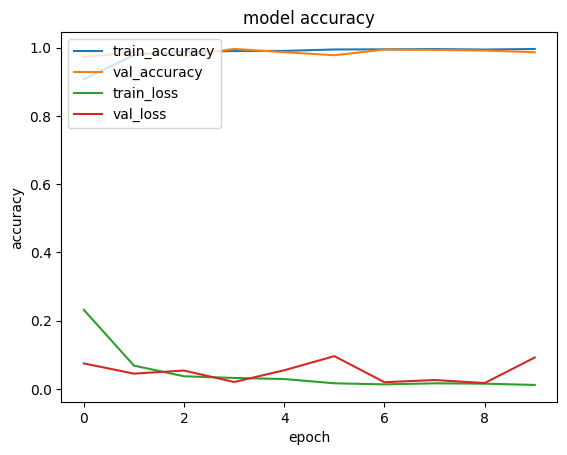

K-Fold Results:
Acuracy: 0.9550228416919708 	 +/- 0.023891085101799932
Precision: 0.9254277944564819 	 +/- 0.04953458128465773
Recall: 0.9041850566864014 	 +/- 0.047655296556985395
AUC: 0.9836412838763906 	 +/- 0.015485853220139878
F1: 0.9135116827074491 	 +/- 0.03563197038888848


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9555349946022034, Test Precision: 0.8561872839927673, Test Recall: 0.9808428883552551, Test AUC: 0.9837357843171675, Test F1 Score: 0.9142857000885569


In [16]:
# no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8863636255264282, Val Recall: 0.8823529481887817, Val AUC: 0.9610596241252983, Val F1 Score: 0.8843537396246153
Test Accuracy: 0.962945818901062, Test Precision: 0.88908451795578, Test Recall: 0.967432975769043, Test AUC: 0.991904170089665,Test F1 Score: 0.926605522246305

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9382715821266174, Val Precision: 0.875, Val Recall: 0.8783270120620728, Val AUC: 0.9755691389517256, Val F1 Score: 0.8766603494580797
Test Accuracy: 0.9462714195251465, Test Precision: 0.862500011920929, Test Recall: 0.9252873659133911, Test AUC: 0.9888433659366611,Test F1 Score: 0.8927911383929052

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9404537081718445, Val Precision: 0.9027777910232544, Val Recall: 0.8813559412956238, Val AUC: 0.9639269609258724, Val F1 Scor

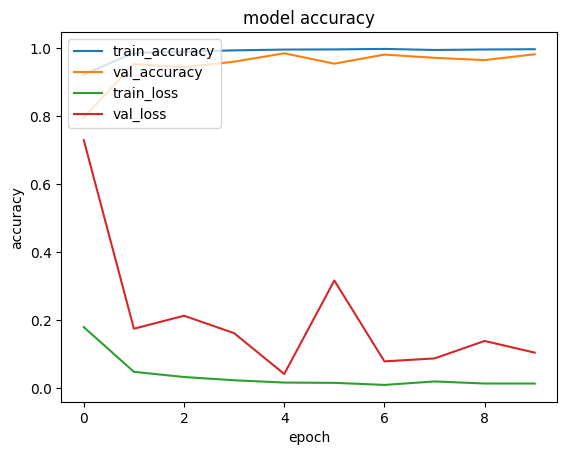

K-Fold Results:
Acuracy: 0.9552104622125626 	 +/- 0.019592927651866664
Precision: 0.9102562516927719 	 +/- 0.03175874188654669
Recall: 0.9190751761198044 	 +/- 0.04989957842173844
AUC: 0.979487584388123 	 +/- 0.01601111954864235
F1: 0.9138772091910907 	 +/- 0.031199855146125978


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9481241106987, Test Precision: 0.8740875720977783, Test Recall: 0.9176245331764221, Test AUC: 0.991569476919044, Test F1 Score: 0.8953270985226575


In [17]:
# smote
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8662477731704712, Val Precision: 0.7117646932601929, Val Recall: 0.5475113391876221, Val AUC: 0.8599058539773907, Val F1 Score: 0.6189258436624848
Test Accuracy: 0.8522464036941528, Test Precision: 0.8103975653648376, Test Recall: 0.507662832736969, Test AUC: 0.8362554621691393,Test F1 Score: 0.6242638414275146

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7758784294128418, Val Precision: 0.8292682766914368, Val Recall: 0.1292775720357895, Val AUC: 0.7105356885017086, Val F1 Score: 0.22368421817135178
Test Accuracy: 0.7698008418083191, Test Precision: 0.8205128312110901, Test Recall: 0.061302680522203445, Test AUC: 0.7856418970315291,Test F1 Score: 0.11408199399267382

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7684310078620911, Val Precision: 0.6068376302719116, Val Recall: 0.4813559353351593, Val AUC: 0.722029

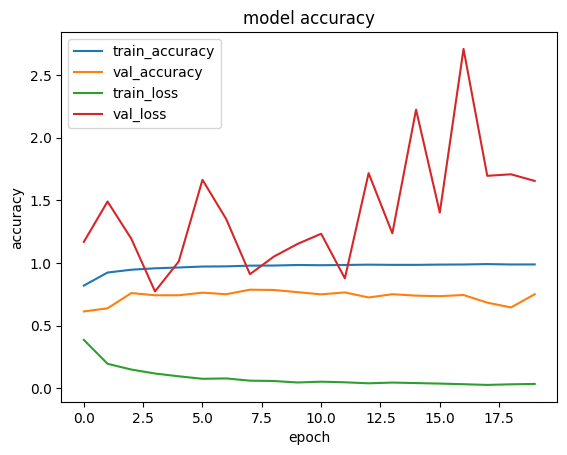

K-Fold Results:
Acuracy: 0.7791413813829422 	 +/- 0.04495708351753779
Precision: 0.6014806283637881 	 +/- 0.2133020002128203
Recall: 0.3084369017742574 	 +/- 0.20501959627310629
AUC: 0.7134087697044207 	 +/- 0.1201388293450086
F1: 0.37765609044798065 	 +/- 0.19935239550485553


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.8615099787712097, Test Precision: 0.7107750177383423, Test Recall: 0.7203065156936646, Test AUC: 0.9086685531190829, Test F1 Score: 0.7155090251795675


In [16]:
# deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, batch_size=32, epochs=20, weights_path=None, learning_rate=0.001, num_classes=1, name="resnet10_no_pretrain__deep_smote_brugada.h5")

# Transfer Learning


Training on fold 1


2024-06-03 17:22:51.990682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-03 17:22:52.044819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9829443693161011, Val Precision: 0.9764150977134705, Val Recall: 0.9366515874862671, Val AUC: 0.9988447097333205, Val F1 Score: 0.9561200959635071
Test Accuracy: 0.9601667523384094, Test Precision: 0.9113207459449768, Test Recall: 0.9252873659133911, Test AUC: 0.9863302415174005,Test F1 Score: 0.9182509508404928

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9477682709693909, Val Precision: 0.9561403393745422, Val Recall: 0.8288973569869995, Val AUC: 0.944664773547673, Val F1 Score: 0.8879837124242884
Test Accuracy: 0.9680407643318176, Test Precision: 0.9557344317436218, Test Recall: 0.9099617004394531, Test AUC: 0.9817071458162183,Test F1 Score: 0.9322865751566252

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.8979206085205078, Val Precision: 0.8912134170532227, Val Recall: 0.7220339179039001, Val AUC: 0.9313526001288402, Val F1 Score

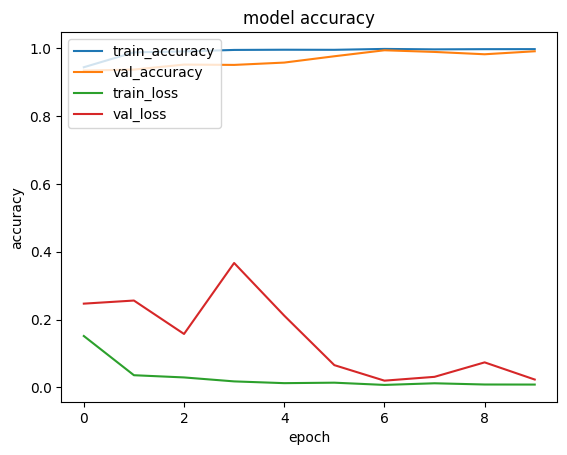

K-Fold Results:
Acuracy: 0.9501484110951424 	 +/- 0.031210351991314396
Precision: 0.9347561597824097 	 +/- 0.04342580673155319
Recall: 0.8724537938833237 	 +/- 0.0870048433371881
AUC: 0.9775633687105822 	 +/- 0.024410407436563555
F1: 0.9008017133838784 	 +/- 0.05898993567311808


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9745252728462219, Test Precision: 0.9533980488777161, Test Recall: 0.9406130313873291, Test AUC: 0.9962856079596121, Test F1 Score: 0.9469623892043331


In [7]:
# ptbxl No smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_no_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9838420152664185, Val Precision: 0.9356223344802856, Val Recall: 0.9864253401756287, Val AUC: 0.9945909107031563, Val F1 Score: 0.9603524321849648
Test Accuracy: 0.9638721346855164, Test Precision: 0.8950178027153015, Test Recall: 0.9636015295982361, Test AUC: 0.9895566368719529,Test F1 Score: 0.9280442839692022

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9553655982017517, Val Precision: 0.9615384340286255, Val Recall: 0.855513334274292, Val AUC: 0.9633344563700246, Val F1 Score: 0.9054325981003917
Test Accuracy: 0.958314061164856, Test Precision: 0.9302788972854614, Test Recall: 0.8946360349655151, Test AUC: 0.986828770505808,Test F1 Score: 0.9121093913709046

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9376181364059448, Val Precision: 0.8989546895027161, Val Recall: 0.8745762705802917, Val AUC: 0.970935424395

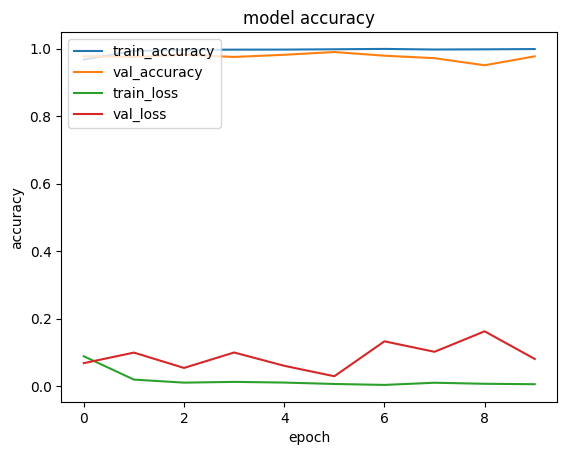

K-Fold Results:
Acuracy: 0.9564328044652939 	 +/- 0.018408873824631366
Precision: 0.9068304300308228 	 +/- 0.0738103798476
Recall: 0.9292140752077103 	 +/- 0.060370699119417615
AUC: 0.9857593748566027 	 +/- 0.012768943091836168
F1: 0.9138929166596237 	 +/- 0.0362254050245637


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9597035646438599, Test Precision: 0.8863232731819153, Test Recall: 0.9559386968612671, Test AUC: 0.989928193101576, Test F1 Score: 0.9198156706708471


In [8]:
# ptbxl SMOTE
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8213644623756409, Val Precision: 0.7115384340286255, Val Recall: 0.16742081940174103, Val AUC: 0.849432235638678, Val F1 Score: 0.271062275517284
Test Accuracy: 0.7721167206764221, Test Precision: 0.720588207244873, Test Recall: 0.09386973083019257, Test AUC: 0.8463957290342816,Test F1 Score: 0.16610169265058594

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7663817405700684, Val Precision: 0.6734693646430969, Val Recall: 0.12547528743743896, Val AUC: 0.7223131347162729, Val F1 Score: 0.21153846361908876
Test Accuracy: 0.8360351920127869, Test Precision: 0.942105233669281, Test Recall: 0.34291186928749084, Test AUC: 0.8584727693168279,Test F1 Score: 0.5028089758489841

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7948960065841675, Val Precision: 0.6666666865348816, Val Recall: 0.5288135409355164, Val AUC: 0.7793811

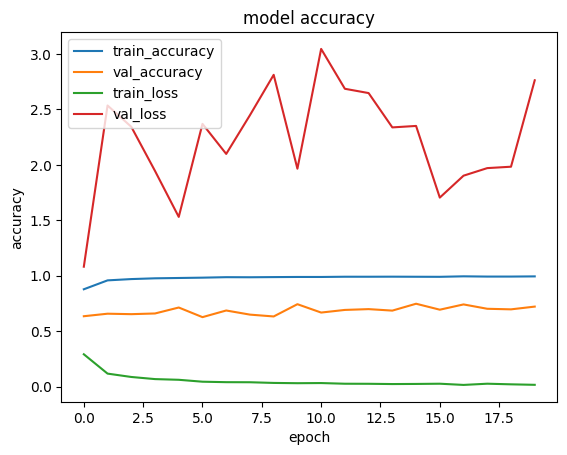

K-Fold Results:
Acuracy: 0.7763475254178047 	 +/- 0.0339385008440797
Precision: 0.5967136211693287 	 +/- 0.0959815351051665
Recall: 0.3744742553681135 	 +/- 0.19811688789530388
AUC: 0.7382874049545779 	 +/- 0.07379841675127746
F1: 0.4275611676715465 	 +/- 0.14689981306038993


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.7336729764938354, Test Precision: 0.4626234173774719, Test Recall: 0.6283524632453918, Test AUC: 0.7655591365384299, Test F1 Score: 0.5329000741944422


In [9]:
# ptbxl Deep SMOTE
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=20, weights_path='model-weights/resnet_feature_model_ptbxl_classifier.h5', learning_rate=0.001, num_classes=1, name="resnet10_deep_smote_transfer.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9234449863433838, Val Recall: 0.8733031749725342, Val AUC: 0.9406292278303344, Val F1 Score: 0.8976744274450934
Test Accuracy: 0.9615562558174133, Test Precision: 0.8912655711174011, Test Recall: 0.9578543901443481, Test AUC: 0.9929375059975611,Test F1 Score: 0.9233610127671623

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9610636234283447, Val Precision: 0.9586777091026306, Val Recall: 0.8821292519569397, Val AUC: 0.9908215815565288, Val F1 Score: 0.9188118779295829
Test Accuracy: 0.9689671397209167, Test Precision: 0.9417475461959839, Test Recall: 0.9291187524795532, Test AUC: 0.9950591798378962,Test F1 Score: 0.9353905256529962

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9499054551124573, Val Precision: 0.8954248428344727, Val Recall: 0.9288135766983032, Val AUC: 0.962374214

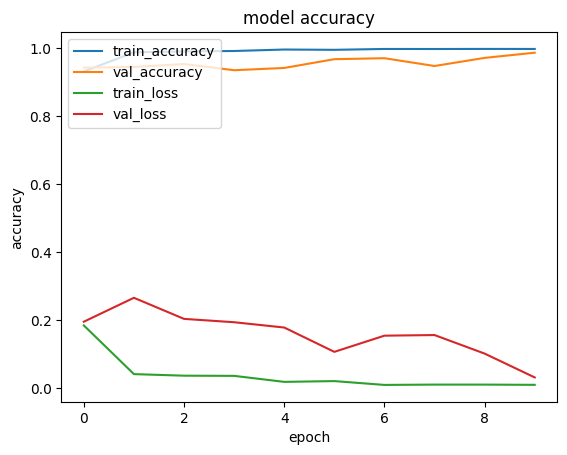

K-Fold Results:
Acuracy: 0.9591707587242126 	 +/- 0.014332292787842142
Precision: 0.898608610033989 	 +/- 0.06643109508922188
Recall: 0.947079986333847 	 +/- 0.04507200232985468
AUC: 0.9841868106154232 	 +/- 0.019965639683247233
F1: 0.9194102083155364 	 +/- 0.030885079498915145


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9578508734703064, Test Precision: 0.8882882595062256, Test Recall: 0.9444444179534912, Test AUC: 0.987406876891426, Test F1 Score: 0.9155060075505385


In [11]:
# norm+rbbb no smote
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_no_smote_transfer_rbbb.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9614003300666809, Val Precision: 0.9009009003639221, Val Recall: 0.9049773812294006, Val AUC: 0.9904789894250403, Val F1 Score: 0.902934539795471
Test Accuracy: 0.962945818901062, Test Precision: 0.8946428298950195, Test Recall: 0.959770143032074, Test AUC: 0.9967513697844622,Test F1 Score: 0.9260628450583217

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9686609506607056, Val Precision: 0.9791666865348816, Val Recall: 0.8935361504554749, Val AUC: 0.9928526736294941, Val F1 Score: 0.9343936629547875
Test Accuracy: 0.9610931277275085, Test Precision: 0.9101123809814453, Test Recall: 0.931034505367279, Test AUC: 0.9849540206479941,Test F1 Score: 0.9204545674637761

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.95652174949646, Val Precision: 0.9249146580696106, Val Recall: 0.9186440706253052, Val AUC: 0.986076371148677

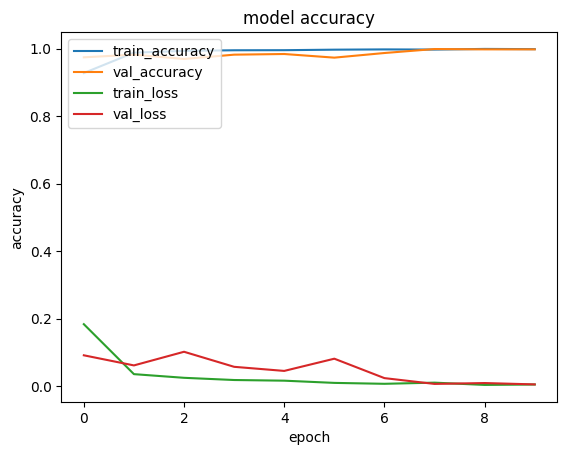

K-Fold Results:
Acuracy: 0.9730071276426315 	 +/- 0.013481210339315068
Precision: 0.9337734878063202 	 +/- 0.03962843710514402
Recall: 0.9601814895868301 	 +/- 0.043080973378465476
AUC: 0.9952325085059057 	 +/- 0.00476927716886425
F1: 0.945884831631617 	 +/- 0.029546922772200897


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.9735988974571228, Test Precision: 0.9622266292572021, Test Recall: 0.9272030591964722, Test AUC: 0.9956419672468796, Test F1 Score: 0.9443902355718301


In [9]:
# norm+rbbb smote freeze 8
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer_rbbb_freeze8.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.979353666305542, Val Precision: 0.9852941036224365, Val Recall: 0.9095022678375244, Val AUC: 0.9788703490699406, Val F1 Score: 0.9458823493957519
Test Accuracy: 0.9833256006240845, Test Precision: 0.9783464670181274, Test Recall: 0.9521072506904602, Test AUC: 0.9984096223116298,Test F1 Score: 0.9650485338141298

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9325736165046692, Val Precision: 0.9948453903198242, Val Recall: 0.73384028673172, Val AUC: 0.9414015497906338, Val F1 Score: 0.8446389487430936
Test Accuracy: 0.966651201248169, Test Precision: 0.9360465407371521, Test Recall: 0.9252873659133911, Test AUC: 0.995453556056425,Test F1 Score: 0.930635857388515

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9489603042602539, Val Precision: 0.8976897597312927, Val Recall: 0.9220339059829712, Val AUC: 0.990852344669791

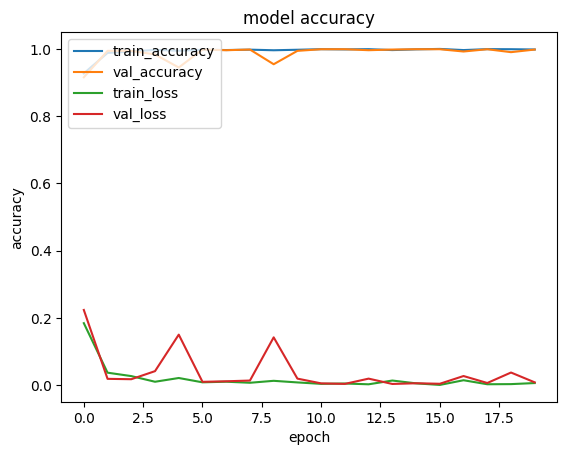

K-Fold Results:
Acuracy: 0.9695446640253067 	 +/- 0.019719098344718227
Precision: 0.95297010242939 	 +/- 0.03992948480906574
Recall: 0.929270550608635 	 +/- 0.0791867777814087
AUC: 0.9870210012719451 	 +/- 0.01834422903141645
F1: 0.9381546314865583 	 +/- 0.04340083851317623


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.983788788318634, Test Precision: 0.976516604423523, Test Recall: 0.9559386968612671, Test AUC: 0.9953400412398159, Test F1 Score: 0.9661180878806175


In [14]:
# norm+rbbb smoote freeze 8 (20 epochs, results not saved)
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_smote_transfer_rbbb.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.6157989501953125, Val Precision: 0.25298330187797546, Val Recall: 0.479638010263443, Val AUC: 0.5885798543726217, Val F1 Score: 0.3312500074232229
Test Accuracy: 0.6813339591026306, Test Precision: 0.3669871687889099, Test Recall: 0.43869730830192566, Test AUC: 0.653866408274177,Test F1 Score: 0.3996509494892204

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.6020892858505249, Val Precision: 0.36505189538002014, Val Recall: 0.802281379699707, Val AUC: 0.7002671222986956, Val F1 Score: 0.5017835857843986
Test Accuracy: 0.4844835698604584, Test Precision: 0.24808184802532196, Test Recall: 0.5574712753295898, Test AUC: 0.5112549355540108,Test F1 Score: 0.343362840252724

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7117202281951904, Val Precision: 0.4695121943950653, Val Recall: 0.26101693511009216, Val AUC: 0.70753937

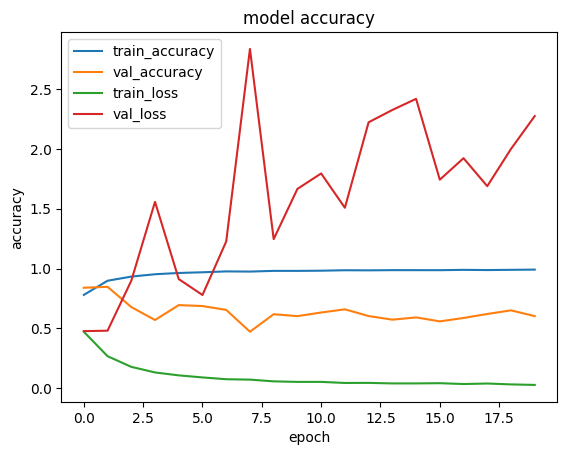

K-Fold Results:
Acuracy: 0.6864400282502174 	 +/- 0.07599543342428512
Precision: 0.406335711479187 	 +/- 0.07569456959914894
Recall: 0.3771863607689738 	 +/- 0.22214534643407072
AUC: 0.698605687586288 	 +/- 0.06209730497890414
F1: 0.34152904805177997 	 +/- 0.13156961377284593


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.4844835698604584, Test Precision: 0.24808184802532196, Test Recall: 0.5574712753295898, Test AUC: 0.5112549355540108, Test F1 Score: 0.343362840252724


In [15]:
# norm+rbbb deep smote
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=20, weights_path='model-weights/Norm_RBBB_resnet_feature_extractor.h5', learning_rate=0.001, num_classes=1, name="resnet10_deep_smote_transfer_rbbb.h5")

# SimCLR


Training on fold 1


68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9533213376998901, Val Precision: 0.9941520690917969, Val Recall: 0.7692307829856873, Val AUC: 0.9983126681631392, Val F1 Score: 0.8673469560094386
Test Accuracy: 0.9587771892547607, Test Precision: 0.9253438115119934, Test Recall: 0.9022988677024841, Test AUC: 0.9909469008114553,Test F1 Score: 0.9136760515153094

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9515669345855713, Val Precision: 0.9380165338516235, Val Recall: 0.8631178736686707, Val AUC: 0.9803388362131202, Val F1 Score: 0.8990099048506991
Test Accuracy: 0.9592403769493103, Test Precision: 0.8767361044883728, Test Recall: 0.967432975769043, Test AUC: 0.983347844505766,Test F1 Score: 0.9198542884266909

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9319470524787903, Val Precision: 0.8562300205230713, Val Recall: 0.9084745645523071, Val AUC: 0.951027389652798, Val F1 Score: 

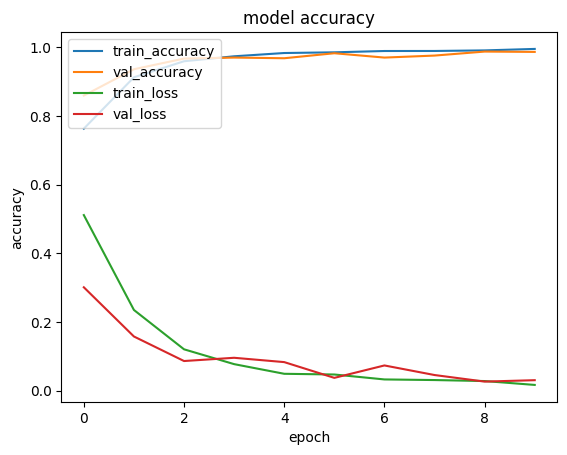

K-Fold Results:
Acuracy: 0.9523432084492275 	 +/- 0.021904541172847767
Precision: 0.9275333285331726 	 +/- 0.038042086168838835
Recall: 0.8791363835334778 	 +/- 0.0902178555994823
AUC: 0.9846635770395592 	 +/- 0.015730809577934227
F1: 0.8994340286362966 	 +/- 0.04796246312624626


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9592403769493103, Test Precision: 0.8793706297874451, Test Recall: 0.9636015295982361, Test AUC: 0.9877743372256043, Test F1 Score: 0.919561242020496


In [18]:
# PTB-XL
# No SMOTE
k_fold_finetune_resnet(7, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_SimCLR_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9694793820381165, Val Precision: 0.9746192693710327, Val Recall: 0.8687782883644104, Val AUC: 0.9978160960309699, Val F1 Score: 0.9186602825831204
Test Accuracy: 0.9638721346855164, Test Precision: 0.9051094651222229, Test Recall: 0.9501915574073792, Test AUC: 0.9950392854885936,Test F1 Score: 0.9271027847718688

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.94017094373703, Val Precision: 0.8472222089767456, Val Recall: 0.927756667137146, Val AUC: 0.9889926360879819, Val F1 Score: 0.8856624306940781
Test Accuracy: 0.9518295526504517, Test Precision: 0.857876718044281, Test Recall: 0.959770143032074, Test AUC: 0.9872863405397688,Test F1 Score: 0.9059674659726527

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9413988590240479, Val Precision: 0.95686274766922, Val Recall: 0.8271186351776123, Val AUC: 0.9691094475420396

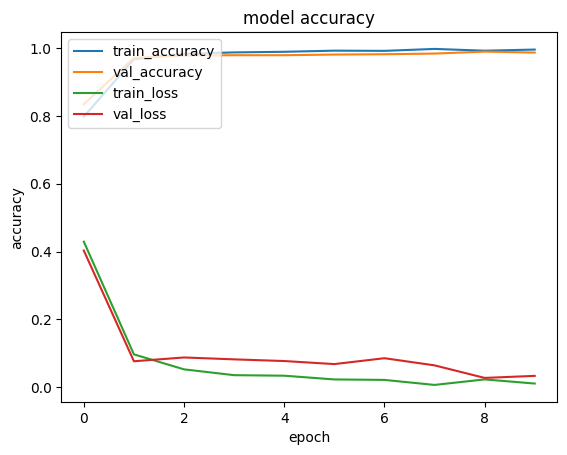

K-Fold Results:
Acuracy: 0.9608869254589081 	 +/- 0.019153274190385493
Precision: 0.9509717524051666 	 +/- 0.04317763465374885
Recall: 0.8959211781620979 	 +/- 0.04839096331079977
AUC: 0.9843275123049443 	 +/- 0.012465602696666463
F1: 0.9214512453032185 	 +/- 0.03382350672355207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.960629940032959, Test Precision: 0.9309664964675903, Test Recall: 0.9042145609855652, Test AUC: 0.9871938903283035, Test F1 Score: 0.9173955435916975


In [14]:
# BARD
# NO SMOTE
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0003, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9605026841163635, Val Precision: 0.9004524946212769, Val Recall: 0.9004524946212769, Val AUC: 0.9936712388461285, Val F1 Score: 0.9004524946212769
Test Accuracy: 0.9495136737823486, Test Precision: 0.8494077920913696, Test Recall: 0.961685836315155, Test AUC: 0.9833490147616072,Test F1 Score: 0.9020664973888827

Training on fold 2
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9278252720832825, Val Precision: 0.8303886651992798, Val Recall: 0.8935361504554749, Val AUC: 0.9739615921451605, Val F1 Score: 0.8608058594506818
Test Accuracy: 0.9550718069076538, Test Precision: 0.867012083530426, Test Recall: 0.961685836315155, Test AUC: 0.9863665194484819,Test F1 Score: 0.911898276469533

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9395084977149963, Val Precision: 0.8888888955116272, Val Recall: 0.8949152827262878, Val AUC: 0.9619832507719

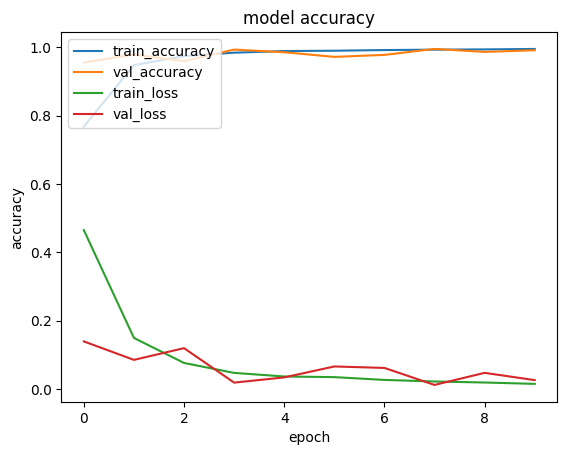

K-Fold Results:
Acuracy: 0.9540170356631279 	 +/- 0.02070510891786806
Precision: 0.9053485244512558 	 +/- 0.042582010462747524
Recall: 0.9131535887718201 	 +/- 0.0674687719816852
AUC: 0.9856975296430306 	 +/- 0.013839340507715701
F1: 0.907859245666982 	 +/- 0.0450160110654207


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.966651201248169, Test Precision: 0.8892733454704285, Test Recall: 0.984674334526062, Test AUC: 0.9889481038344603, Test F1 Score: 0.9345454507721357


In [15]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9730700254440308, Val Precision: 0.9321267008781433, Val Recall: 0.9321267008781433, Val AUC: 0.9954801801847452, Val F1 Score: 0.9321267008781433
Test Accuracy: 0.9448819160461426, Test Precision: 0.8386554718017578, Test Recall: 0.9559386968612671, Test AUC: 0.9774860329965337,Test F1 Score: 0.8934646426796466

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9439696073532104, Val Precision: 0.8777777552604675, Val Recall: 0.9011406898498535, Val AUC: 0.9773932714058815, Val F1 Score: 0.889305807227401
Test Accuracy: 0.9462714195251465, Test Precision: 0.8274193406105042, Test Recall: 0.982758641242981, Test AUC: 0.9800775645571635,Test F1 Score: 0.8984238180644919

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9413988590240479, Val Precision: 0.8794788122177124, Val Recall: 0.9152542352676392, Val AUC: 0.96089921585

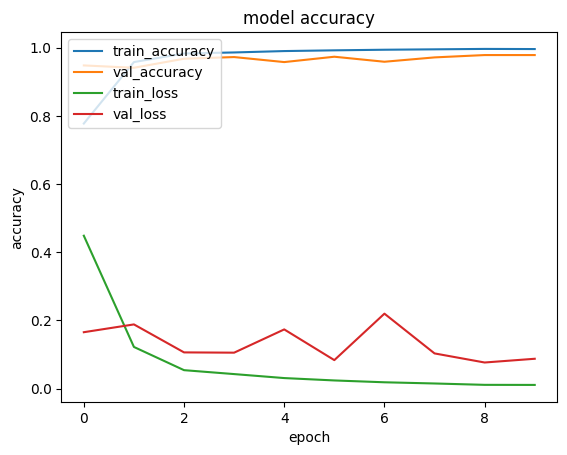

K-Fold Results:
Acuracy: 0.9564163684844971 	 +/- 0.014633546105888596
Precision: 0.9111796393990517 	 +/- 0.044727272706775574
Recall: 0.9179079979658127 	 +/- 0.060474228140907034
AUC: 0.9839292242470787 	 +/- 0.012683247435261585
F1: 0.912526120276388 	 +/- 0.03153274408421686


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [16]:
# SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8976660966873169, Val Precision: 0.7955800890922546, Val Recall: 0.651583731174469, Val AUC: 0.9356533723834956, Val F1 Score: 0.7164179143219666
Test Accuracy: 0.8374247550964355, Test Precision: 0.6904231905937195, Test Recall: 0.5938697457313538, Test AUC: 0.8817011775114277,Test F1 Score: 0.6385170128213487

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7568851113319397, Val Precision: 0.5087282061576843, Val Recall: 0.7756654024124146, Val AUC: 0.8163474033787359, Val F1 Score: 0.6144578517284168
Test Accuracy: 0.7012505531311035, Test Precision: 0.4295532703399658, Test Recall: 0.7183908224105835, Test AUC: 0.7602169186227493,Test F1 Score: 0.537634418082659

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7372400760650635, Val Precision: 0.5255255103111267, Val Recall: 0.5932203531265259, Val AUC: 0.76601061821

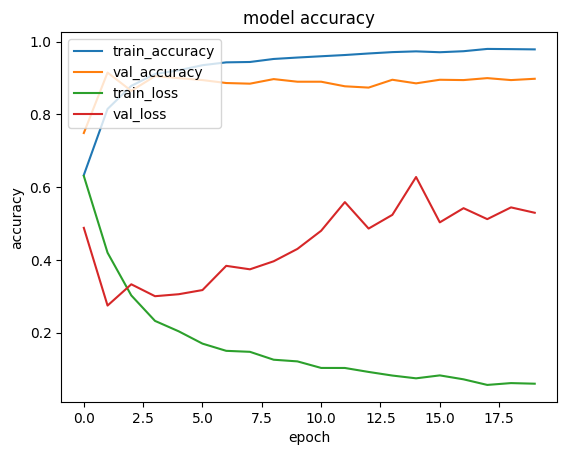

K-Fold Results:
Acuracy: 0.7642235457897186 	 +/- 0.055467524364266836
Precision: 0.5432984456419945 	 +/- 0.1118012773414976
Recall: 0.7340260222554207 	 +/- 0.10542568105441988
AUC: 0.8260891643258189 	 +/- 0.04781558568118828
F1: 0.6122348295579882 	 +/- 0.05977433641937083


68/68 [==============================] - 1s 3ms/step

Test Performance:
Test Accuracy: 0.8374247550964355, Test Precision: 0.6904231905937195, Test Recall: 0.5938697457313538, Test AUC: 0.8817011775114277, Test F1 Score: 0.6385170128213487


In [17]:
# Deep SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_ptbxl_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9138240814208984, Val Precision: 0.8140703439712524, Val Recall: 0.733031690120697, Val AUC: 0.9452858583350646, Val F1 Score: 0.7714285767436566
Test Accuracy: 0.8480778336524963, Test Precision: 0.7449495196342468, Test Recall: 0.5651341080665588, Test AUC: 0.8798229168860897,Test F1 Score: 0.6427015397054605

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.8328585028648376, Val Precision: 0.6355140209197998, Val Recall: 0.7756654024124146, Val AUC: 0.9072459931655196, Val F1 Score: 0.69863013961966
Test Accuracy: 0.7378416061401367, Test Precision: 0.4715026021003723, Test Recall: 0.6973180174827576, Test AUC: 0.7797180619627063,Test F1 Score: 0.5625966110212155

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7854442596435547, Val Precision: 0.625, Val Recall: 0.5762711763381958, Val AUC: 0.7788324410778151, Val F1 

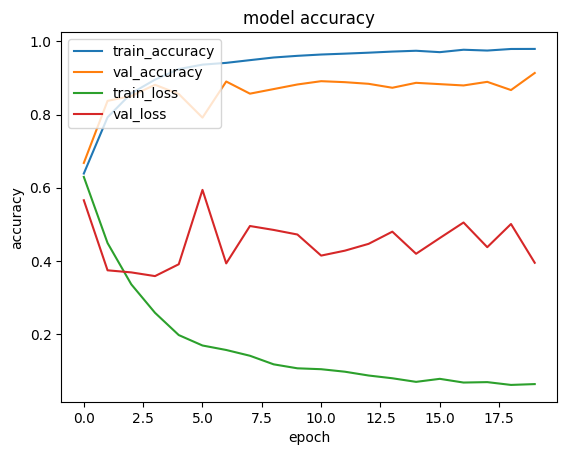

K-Fold Results:
Acuracy: 0.8363684117794037 	 +/- 0.043574728759249344
Precision: 0.7167941704392433 	 +/- 0.09911860024255859
Recall: 0.6214459128677845 	 +/- 0.10550238855876044
AUC: 0.8541748629496269 	 +/- 0.05292978176529819
F1: 0.6557626201587627 	 +/- 0.07049634707085385


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.8480778336524963, Test Precision: 0.7449495196342468, Test Recall: 0.5651341080665588, Test AUC: 0.8798229168860897, Test F1 Score: 0.6427015397054605


In [18]:
# Deep SMOTE
# BARD
k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=20, weights_path='model-weights/resnet10_simclr_model.h5', learning_rate=0.0001, num_classes=1, name="resnet10_bard_deep_smote_brugada.h5")

# MoCo v2


Training on fold 1
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8761062026023865, Val Recall: 0.8959276080131531, Val AUC: 0.9894149062846778, Val F1 Score: 0.8859060473461146
Test Accuracy: 0.9550718069076538, Test Precision: 0.8708551526069641, Test Recall: 0.9559386968612671, Test AUC: 0.9836632284550049,Test F1 Score: 0.91141552724228

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9316239356994629, Val Precision: 0.9321267008781433, Val Recall: 0.7832699418067932, Val AUC: 0.9627039514848148, Val F1 Score: 0.8512396591969764
Test Accuracy: 0.9620194435119629, Test Precision: 0.9166666865348816, Test Recall: 0.9272030591964722, Test AUC: 0.9834420501009932,Test F1 Score: 0.9219047690177449

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9187145829200745, Val Precision: 0.8884758353233337, Val Recall: 0.810169517993927, Val AUC: 0.946171446342

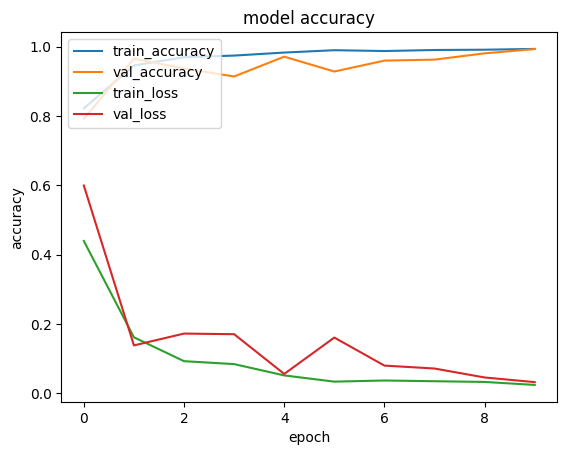

K-Fold Results:
Acuracy: 0.9473043233156204 	 +/- 0.031379172725056886
Precision: 0.897677406668663 	 +/- 0.054913521918609334
Recall: 0.9053474068641663 	 +/- 0.07087380807589685
AUC: 0.9743871175612816 	 +/- 0.017750832684060493
F1: 0.8994550431619386 	 +/- 0.04840733849475024


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.946734607219696, Test Precision: 0.8397328853607178, Test Recall: 0.9636015295982361, Test AUC: 0.9841845774323184, Test F1 Score: 0.8974130212071015


In [20]:
# NO SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="resnet10_ptbxl_moco_no_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9326750636100769, Val Precision: 0.929411768913269, Val Recall: 0.7149321436882019, Val AUC: 0.9613687149422608, Val F1 Score: 0.80818415566969
Test Accuracy: 0.9351551532745361, Test Precision: 0.873046875, Test Recall: 0.8563218116760254, Test AUC: 0.967234591826465,Test F1 Score: 0.864603467656226

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9259259104728699, Val Precision: 0.9468598961830139, Val Recall: 0.7452471256256104, Val AUC: 0.9388265870914955, Val F1 Score: 0.8340425362059194
Test Accuracy: 0.9383974075317383, Test Precision: 0.843033492565155, Test Recall: 0.9157088398933411, Test AUC: 0.9771934690362007,Test F1 Score: 0.877869608550276

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9035916924476624, Val Precision: 0.8814229369163513, Val Recall: 0.7559322118759155, Val AUC: 0.9569584823511118, Val F

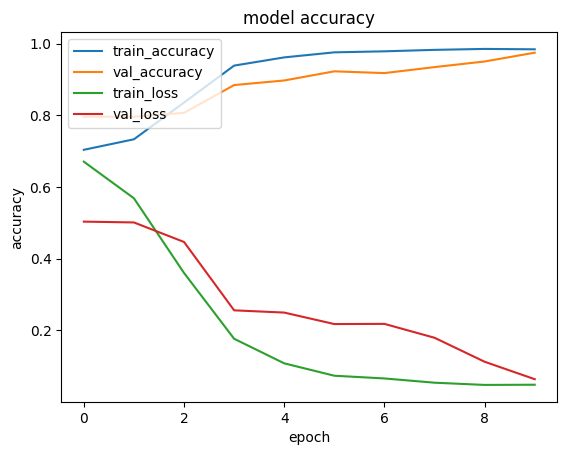

K-Fold Results:
Acuracy: 0.9269064739346504 	 +/- 0.021699992716573798
Precision: 0.9094995409250259 	 +/- 0.044785541800677155
Recall: 0.7956976518034935 	 +/- 0.09215751443214334
AUC: 0.9632544394355219 	 +/- 0.01703180624714246
F1: 0.8442176847453002 	 +/- 0.04512777158021462


68/68 [==============================] - 1s 5ms/step

Test Performance:
Test Accuracy: 0.9462714195251465, Test Precision: 0.8980392217636108, Test Recall: 0.8773946166038513, Test AUC: 0.9753403689114515, Test F1 Score: 0.887596892260454


In [10]:
# NO SMOTE
# BARD

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_6.h5', learning_rate=0.0001, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9802513718605042, Val Precision: 0.9383260011672974, Val Recall: 0.9638009071350098, Val AUC: 0.9971117743333012, Val F1 Score: 0.950892863316433
Test Accuracy: 0.9564613103866577, Test Precision: 0.8702422380447388, Test Recall: 0.9636015295982361, Test AUC: 0.9890230002083056,Test F1 Score: 0.9145454661917093

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9420702457427979, Val Precision: 0.9316239356994629, Val Recall: 0.8288973569869995, Val AUC: 0.9437647398565723, Val F1 Score: 0.8772635937038209
Test Accuracy: 0.9675775766372681, Test Precision: 0.9139193892478943, Test Recall: 0.9559386968612671, Test AUC: 0.993957383963282,Test F1 Score: 0.934456915724324

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9177693724632263, Val Precision: 0.8270440101623535, Val Recall: 0.8915254473686218, Val AUC: 0.972979096785

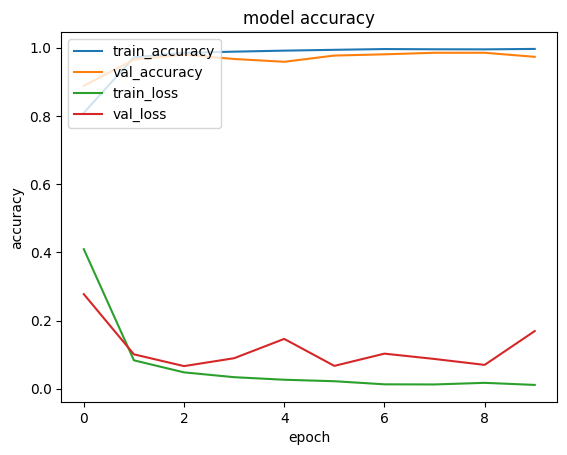

K-Fold Results:
Acuracy: 0.9534400701522827 	 +/- 0.020120794818621678
Precision: 0.895521953701973 	 +/- 0.052302830734009556
Recall: 0.9277016520500183 	 +/- 0.04636124023895939
AUC: 0.983462003345432 	 +/- 0.01736594515023358
F1: 0.9098423875644978 	 +/- 0.034288208131423095


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9624826312065125, Test Precision: 0.8916518688201904, Test Recall: 0.961685836315155, Test AUC: 0.9883846256468589, Test F1 Score: 0.9253456299867325


In [22]:
# SMOTE
# PTB-XL
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9676840305328369, Val Precision: 0.9111111164093018, Val Recall: 0.9276018142700195, Val AUC: 0.98839896023876, Val F1 Score: 0.919282516026694
Test Accuracy: 0.9509031772613525, Test Precision: 0.8421052694320679, Test Recall: 0.9808428883552551, Test AUC: 0.9947683712613251,Test F1 Score: 0.9061946838592358

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9259259104728699, Val Precision: 0.9601989984512329, Val Recall: 0.73384028673172, Val AUC: 0.9665880540982819, Val F1 Score: 0.8318965380627099
Test Accuracy: 0.9661880731582642, Test Precision: 0.9276190400123596, Test Recall: 0.9329501986503601, Test AUC: 0.9823209450049969,Test F1 Score: 0.9302769815472256

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9035916924476624, Val Precision: 0.8271186351776123, Val Recall: 0.8271186351776123, Val AUC: 0.96692582802052

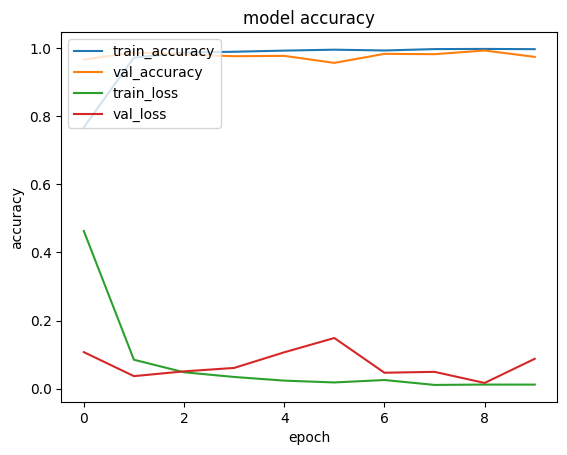

K-Fold Results:
Acuracy: 0.9463710710406303 	 +/- 0.023001698448662383
Precision: 0.9020905122160912 	 +/- 0.04957612658505849
Recall: 0.893737442791462 	 +/- 0.08426310085902362
AUC: 0.9825169075410546 	 +/- 0.012080501715207389
F1: 0.8941516036631655 	 +/- 0.03983934874494614


68/68 [==============================] - 0s 3ms/step

Test Performance:
Test Accuracy: 0.9476609826087952, Test Precision: 0.8495726585388184, Test Recall: 0.9521072506904602, Test AUC: 0.9921083797339775, Test F1 Score: 0.8979223046664304


In [12]:
# SMOTE
# BARD

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=10, weights_path='model-weights/test_moco_BARD_6.h5', learning_rate=0.0005, num_classes=1)


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7280071973800659, Val Precision: 0.21917808055877686, Val Recall: 0.14479638636112213, Val AUC: 0.541633519632334, Val F1 Score: 0.17438692501175962
Test Accuracy: 0.7257989645004272, Test Precision: 0.3758865296840668, Test Recall: 0.20306512713432312, Test AUC: 0.6010820185508956,Test F1 Score: 0.2636815873637552

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7350427508354187, Val Precision: 0.4375, Val Recall: 0.21292775869369507, Val AUC: 0.6362107137700341, Val F1 Score: 0.2864450146333971
Test Accuracy: 0.7142195701599121, Test Precision: 0.3442623019218445, Test Recall: 0.20114941895008087, Test AUC: 0.6448846946919536,Test F1 Score: 0.2539298638001119

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7306238412857056, Val Precision: 0.7083333134651184, Val Recall: 0.0576271191239357, Val AUC: 0.8186018615189817

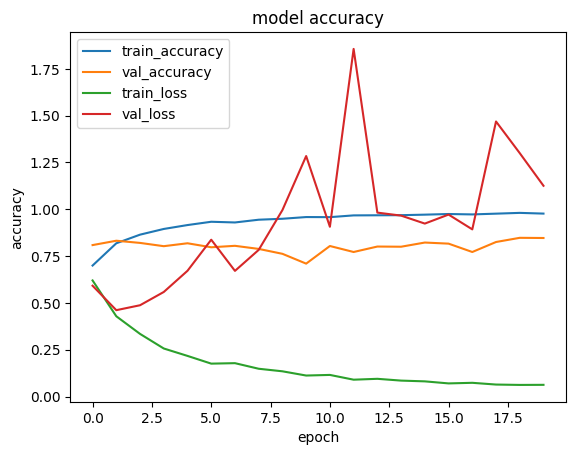

K-Fold Results:
Acuracy: 0.750789001584053 	 +/- 0.05282404198254123
Precision: 0.5406130328774452 	 +/- 0.17115483125518605
Recall: 0.23621338326483965 	 +/- 0.1320295671326956
AUC: 0.6972532352601537 	 +/- 0.08564021541352505
F1: 0.30895221949220036 	 +/- 0.1448933317725948


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.7628531455993652, Test Precision: 0.5146198868751526, Test Recall: 0.3371647596359253, Test AUC: 0.7431428858977149, Test F1 Score: 0.40740741494422156


In [13]:
# Deep SMOTE
# PTB-XL

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_model.h5', learning_rate=0.0005, num_classes=1, name="moco_ptbxl_deep_smote_brugada.h5")


Training on fold 1
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.7208258509635925, Val Precision: 0.3628048896789551, Val Recall: 0.5384615659713745, Val AUC: 0.6984844415843692, Val F1 Score: 0.43351549991425775
Test Accuracy: 0.6442797780036926, Test Precision: 0.2936241626739502, Test Recall: 0.33524903655052185, Test AUC: 0.587631683038546,Test F1 Score: 0.3130590324592891

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.7350427508354187, Val Precision: 0.47752809524536133, Val Recall: 0.6463878154754639, Val AUC: 0.7587765317418298, Val F1 Score: 0.5492730183272224
Test Accuracy: 0.6729967594146729, Test Precision: 0.35975611209869385, Test Recall: 0.4521072804927826, Test AUC: 0.607623163576021,Test F1 Score: 0.40067912647821663

Training on fold 3
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.6843100190162659, Val Precision: 0.3177570104598999, Val Recall: 0.1152542382478714, Val AUC: 0.621089

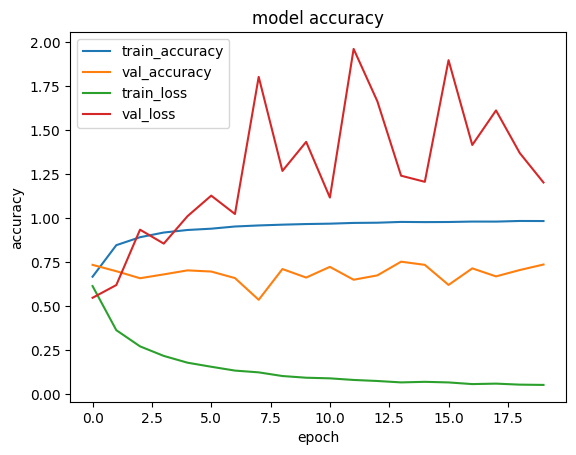

K-Fold Results:
Acuracy: 0.685550145804882 	 +/- 0.05965771612233623
Precision: 0.3650644775480032 	 +/- 0.12842929982799978
Recall: 0.30328015703707933 	 +/- 0.18649554246046
AUC: 0.6067826111583459 	 +/- 0.0949754683613055
F1: 0.30401725221814485 	 +/- 0.1376693748956854


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.6729967594146729, Test Precision: 0.35975611209869385, Test Recall: 0.4521072804927826, Test AUC: 0.607623163576021, Test F1 Score: 0.40067912647821663


In [14]:
# Deep SMOTE
# BARD

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=6, batch_size=32, epochs=20, weights_path='model-weights/test_moco_BARD_6.h5', learning_rate=0.0005, num_classes=1, name="moco_bard_deep_smote_brugada.h5")

# Auto-Encoder

In [8]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = keras.layers.Conv1D(24, 5, activation='linear', padding='same', name='conv1')(inputs)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    # 100 x 24
    X = keras.layers.MaxPooling1D(2, padding='same')(X)
    X = keras.layers.Dropout(0.3)(X)
    # 50 x 24
    X = keras.layers.Conv1D(48, 5, activation='linear', padding='same', name='conv2')(X)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    # 50 x 48
    X = keras.layers.MaxPooling1D(2, padding='same')(X)
    X = keras.layers.Dropout(0.3)(X)
    # 25 x 48
    X = keras.layers.Conv1D(64, 5, activation='linear', padding='same', name='conv3')(X)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    X = keras.layers.BatchNormalization()(X)
    # 25 x 64
    X = keras.layers.MaxPooling1D(2, padding='same')(X)
    X = keras.layers.Dropout(0.3)(X)
    # 13 x 64
    X = keras.layers.Flatten()(X)
    # 832
    X = keras.layers.Dense(latent_dim, activation='linear', name='dense-encode')(X)
    X = keras.layers.LeakyReLU(alpha=0.3)(X)
    return X


In [9]:
def classification_head(inputs, num_classes):
    X = keras.layers.Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense1')(inputs)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense2')(X)
    X = keras.layers.Dropout(0.2)(X)
    X = keras.layers.Dense(num_classes, activation='sigmoid', name='dense3')(X)
    return X

In [10]:
def k_fold_autoencoder_classification(k, X_train, Y_train, folds_train, X_val, Y_val, folds_val, batch_size=32, epochs=5, weights_path=None, learning_rate=0.001, num_classes=1, name="b_model.h5", freeze_layers=3):
    """Carries out k-fold cross validation for fine-tuning a ResNet model on the given data.
    
    Args:
        k (int): The number of folds to use for cross validation.
        X_train (numpy.ndarray): The training data.
        Y_train (numpy.ndarray): The training labels.
        freeze_layers (int): The number of layers to freeze in the ResNet model.
        batch_size (int): The batch size to use for training.
        epochs (int): The number of epochs to train for.
        weights_path (str): The path to the weights file to save the model to.
        learning_rate (float): The learning rate to use for training.
        num_classes (int): The number of classes in the data.
    """
    
    X_input = keras.Input(shape=X_train.shape[1:])
    
    final_history = None
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    val_aucs = []
    
    for i in range(k):
    
        train_index = np.where(folds_train != i)[0]
        val_index = np.where(folds_val == i)[0]
        
        X_train_fold, X_val_fold = X_train[train_index], X_val[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_val[val_index]
        
        print(f"\nTraining on fold {i+1}")
        
        # make model
        enc = encoder(X_input, 256)
        classiifier = classification_head(enc, 1)
        model = keras.Model(inputs=X_input, outputs=classiifier)
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

        # load + freeze weights
        
        layers_to_freeze_substrings = [f"conv{i}" for i in range(1, freeze_layers+1)]
        
        if weights_path:
            model.load_weights(weights_path, by_name=True) # 'model-weights/resnet10_simclr_model.h5'
            for layer in model.layers:
                if any([text in layer.name for text in layers_to_freeze_substrings]):
                    layer.trainable = False
                
        # train
        history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=epochs, batch_size=batch_size, verbose=0)
        
        # evaluate
        val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_val_fold, Y_val_fold, batch_size=32, verbose=0)
        test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, Y_test, batch_size=32, verbose=0)
        
        y_pred = model.predict(X_val_fold)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        val_auc = roc_auc_score(Y_val_fold, y_pred)
        
        y_pred = model.predict(X_test)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        test_auc = roc_auc_score(Y_test, y_pred)
        
        print(f"Val Accuracy: {val_accuracy}, Val AUC: {val_auc}, Val F1 Score: {val_f1}")
        print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
        
        if not val_f1s or val_f1 > max(val_f1s):
            model.save_weights(f'model-weights/fine-tuned/{name}')
            final_history = history
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        val_aucs.append(val_auc)
            
    # plot training history
    plt.plot(final_history.history['accuracy'])
    plt.plot(final_history.history['val_accuracy'])
    plt.plot(final_history.history['loss'])
    plt.plot(final_history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'val_accuracy', 'train_loss', 'val_loss'], loc='upper left')
    plt.show()
    
    # print final results
    print("K-Fold Results:")
    print(f"Acuracy: {np.mean(val_accuracies)} \t +/- {np.std(val_accuracies)}")
    print(f"Precision: {np.mean(val_precisions)} \t +/- {np.std(val_precisions)}")
    print(f"Recall: {np.mean(val_recalls)} \t +/- {np.std(val_recalls)}")
    print(f"AUC: {np.mean(val_aucs)} \t +/- {np.std(val_aucs)}")
    print(f"F1: {np.mean(val_f1s)} \t +/- {np.std(val_f1s)}")

    # load best model
    enc = encoder(X_input, 256)
    classiifier = classification_head(enc, 1)
    model = keras.Model(inputs=X_input, outputs=classiifier)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
    model.load_weights(f'model-weights/fine-tuned/{name}')
    
    # evaluate on test set
    print("\n") # spacer
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, Y_test, batch_size=32)
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    y_pred = model.predict(X_test)
    test_auc = roc_auc_score(Y_test, y_pred)
    print("\nTest Performance:")
    print(f"Test Accuracy: {test_accuracy}, Test AUC: {test_auc}, Test F1 Score: {test_f1}")
    
    


Training on fold 1
68/68 [==============================] - 0s 923us/step
Val Accuracy: 0.9506283402442932, Val AUC: 0.9929415818355941, Val F1 Score: 0.8655256696550961
Test Accuracy: 0.9397869110107422, Test AUC: 0.9747388574090068, Test F1 Score: 0.8722986257133176

Training on fold 2
68/68 [==============================] - 0s 890us/step
Val Accuracy: 0.9221272468566895, Val AUC: 0.978971940126101, Val F1 Score: 0.8373015966190367
Test Accuracy: 0.9546086192131042, Test AUC: 0.9869493068574652, Test F1 Score: 0.9048543465617285

Training on fold 3
68/68 [==============================] - 0s 946us/step
Val Accuracy: 0.8950850367546082, Val AUC: 0.9536974920585558, Val F1 Score: 0.7970749358917882
Test Accuracy: 0.9430291652679443, Test AUC: 0.9737066917569519, Test F1 Score: 0.8838526829410492

Training on fold 4
68/68 [==============================] - 0s 950us/step
Val Accuracy: 0.9194214940071106, Val AUC: 0.9797741152059607, Val F1 Score: 0.8769715988311803
Test Accuracy: 0.951

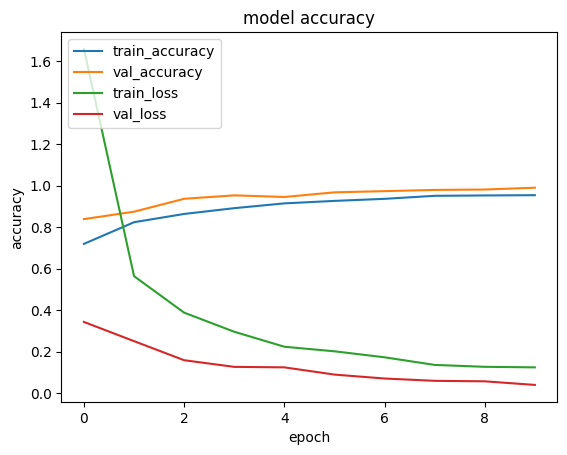

K-Fold Results:
Acuracy: 0.9318112730979919 	 +/- 0.03250140474252044
Precision: 0.9206348285079002 	 +/- 0.04265460974777101
Recall: 0.8049180507659912 	 +/- 0.10415958590337894
AUC: 0.972112349109524 	 +/- 0.021243035975019486
F1: 0.8560162186323206 	 +/- 0.07121273815125749


68/68 [==============================] - 0s 938us/step

Test Performance:
Test Accuracy: 0.9407132863998413, Test AUC: 0.972734209152805, Test F1 Score: 0.8773946166038513


In [49]:
# no smote
k_fold_autoencoder_classification(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_no_smote.h5", freeze_layers=3)


Training on fold 1
68/68 [==============================] - 0s 962us/step
Val Accuracy: 0.9470376968383789, Val AUC: 0.9676012019072423, Val F1 Score: 0.8643678306629232
Test Accuracy: 0.9370078444480896, Test AUC: 0.9790998158017306, Test F1 Score: 0.8719397386029268

Training on fold 2
68/68 [==============================] - 0s 950us/step
Val Accuracy: 0.918328583240509, Val AUC: 0.9725032487847138, Val F1 Score: 0.8300395316164061
Test Accuracy: 0.9462714195251465, Test AUC: 0.9845760280112438, Test F1 Score: 0.8893129612064591

Training on fold 3
68/68 [==============================] - 0s 936us/step
Val Accuracy: 0.920604944229126, Val AUC: 0.9623742141857521, Val F1 Score: 0.8531468401417661
Test Accuracy: 0.9365447163581848, Test AUC: 0.9828036755395465, Test F1 Score: 0.8720821612097259

Training on fold 4
68/68 [==============================] - 0s 926us/step
Val Accuracy: 0.9535123705863953, Val AUC: 0.9896111857772748, Val F1 Score: 0.9319213270146001
Test Accuracy: 0.9536

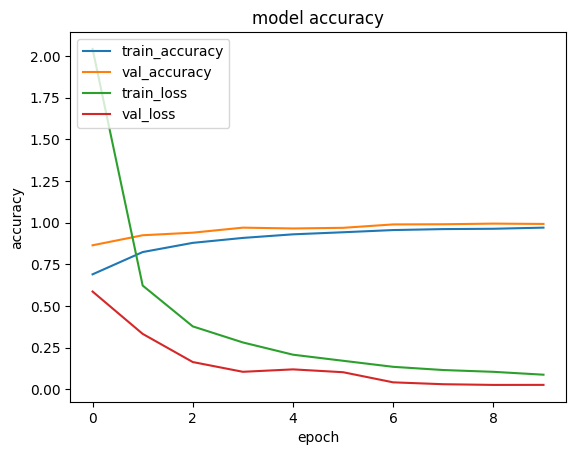

K-Fold Results:
Acuracy: 0.9448612034320831 	 +/- 0.02502929296894625
Precision: 0.9034843295812607 	 +/- 0.04243258133362529
Recall: 0.8733948469161987 	 +/- 0.07993689649587218
AUC: 0.9756677990377185 	 +/- 0.014302451540400793
F1: 0.8869461045989269 	 +/- 0.05540365802878109


68/68 [==============================] - 0s 958us/step

Test Performance:
Test Accuracy: 0.9434923529624939, Test AUC: 0.9873799610070754, Test F1 Score: 0.8876611413268977


In [50]:
# smote
k_fold_autoencoder_classification(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_smote.h5", freeze_layers=3)


Training on fold 1
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9578096866607666, Val AUC: 0.9809985153506661, Val F1 Score: 0.8878281667367081
Test Accuracy: 0.958314061164856, Test AUC: 0.9858118181796904, Test F1 Score: 0.9174311835042817

Training on fold 2
68/68 [==============================] - 0s 992us/step
Val Accuracy: 0.9534662961959839, Val AUC: 0.9845405977763872, Val F1 Score: 0.9037328093520344
Test Accuracy: 0.94210284948349, Test AUC: 0.9814631474733005, Test F1 Score: 0.891398805421966

Training on fold 3
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9310019016265869, Val AUC: 0.9757336117466735, Val F1 Score: 0.8726003468311677
Test Accuracy: 0.9587771892547607, Test AUC: 0.9870230329754691, Test F1 Score: 0.9164319111207865

Training on fold 4
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9163222908973694, Val AUC: 0.9840890335054584, Val F1 Score: 0.8687196288228157
Test Accuracy: 0.962019443511

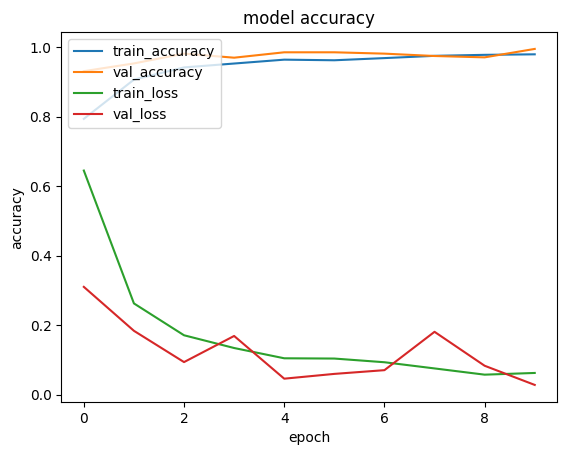

K-Fold Results:
Acuracy: 0.9568328335881233 	 +/- 0.02304416583629407
Precision: 0.9437394663691521 	 +/- 0.0374633969427694
Recall: 0.8876417949795723 	 +/- 0.0689451409402602
AUC: 0.9863841408683904 	 +/- 0.0068125377019245675
F1: 0.9130024850702823 	 +/- 0.039574222747117103


68/68 [==============================] - 0s 1ms/step

Test Performance:
Test Accuracy: 0.9458082318305969, Test AUC: 0.9856971331072399, Test F1 Score: 0.893150679330974


In [12]:
# bard no smote
k_fold_autoencoder_classification(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_bard_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_bard_no_smote.h5", freeze_layers=3)


Training on fold 1
68/68 [==============================] - 0s 994us/step
Val Accuracy: 0.9622980356216431, Val AUC: 0.9923994061402664, Val F1 Score: 0.9027777801003353
Test Accuracy: 0.9573876857757568, Test AUC: 0.9868627079252066, Test F1 Score: 0.91238097297902

Training on fold 2
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9525166153907776, Val AUC: 0.9697646435962843, Val F1 Score: 0.8987854030771277
Test Accuracy: 0.9610931277275085, Test AUC: 0.987196815967907, Test F1 Score: 0.923357660703393

Training on fold 3
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9480150938034058, Val AUC: 0.9846302507941445, Val F1 Score: 0.9090909136016626
Test Accuracy: 0.950439989566803, Test AUC: 0.9934957180338765, Test F1 Score: 0.9047194778269402

Training on fold 4
68/68 [==============================] - 0s 1ms/step
Val Accuracy: 0.9493801593780518, Val AUC: 0.987531536629648, Val F1 Score: 0.9247311851466872
Test Accuracy: 0.96109312772750

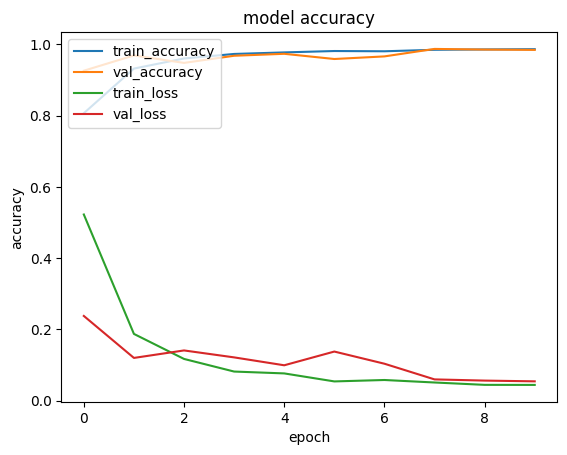

K-Fold Results:
Acuracy: 0.964270792901516 	 +/- 0.012975068251404794
Precision: 0.9296444579958916 	 +/- 0.045387541897033284
Recall: 0.929803878068924 	 +/- 0.0502886066843045
AUC: 0.9895522038406954 	 +/- 0.008510051214709402
F1: 0.9278776074195433 	 +/- 0.024708472261519336


68/68 [==============================] - 0s 1ms/step

Test Performance:
Test Accuracy: 0.9555349946022034, Test AUC: 0.9908140767734642, Test F1 Score: 0.9132007233397792


In [13]:
# bard smote
k_fold_autoencoder_classification(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, batch_size=32, epochs=10, weights_path='temp/ae_brugada_bard_ft.h5', learning_rate=0.001, num_classes=1, name="autoencoder_bard_smote.h5", freeze_layers=3)

In [5]:
# smote data
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s_deep_resampled_per_fold_v2.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(folds_train.shape)

print(X_train_resampled.shape, Y_train_resampled.shape)
print(folds_train_resampled.shape)

print(X_train_resampled_deep.shape, Y_train_resampled_deep.shape)
print(folds_train_resampled_deep.shape)


print(X_test.shape, Y_test.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

Y_train_resampled = np.where(Y_train_resampled == 1, True, False)

(8386, 100, 12) (8386,)
(8386,)
(12544, 100, 12) (12544,)
(12544,)
(12544, 100, 12) (12544,)
(12544,)
(2159, 100, 12) (2159,)


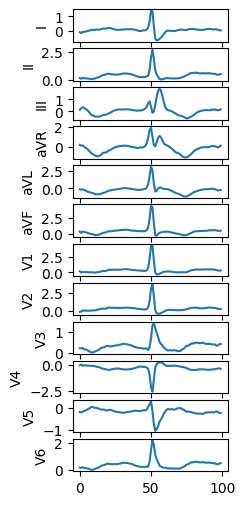

In [18]:
import random

synth = X_train_resampled_deep[8386:]

rand = random.choice(synth)

dv.plot_12_lead_ecg(rand)

# Norm + RBBB dataset pretrained models


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9111310839653015, Val Precision: 0.7147887349128723, Val Recall: 0.918552041053772, Val AUC: 0.9785967276909903, Val F1 Score: 0.8039603994921275
Test Accuracy: 0.9374710321426392, Test Precision: 0.8166939616203308, Test Recall: 0.9559386968612671, Test AUC: 0.9874536871250792,Test F1 Score: 0.8808473178809025

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.8945869207382202, Val Precision: 0.7360248565673828, Val Recall: 0.9011406898498535, Val AUC: 0.9635510420176157, Val F1 Score: 0.8102564196336155
Test Accuracy: 0.9407132863998413, Test Precision: 0.8261589407920837, Test Recall: 0.9559386968612671, Test AUC: 0.9880551986275239,Test F1 Score: 0.8863232682368786

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.760869562625885, Val Precision: 0.5415019989013672, Val Recall: 0.9288135766983032, Val AUC: 0.92625008330

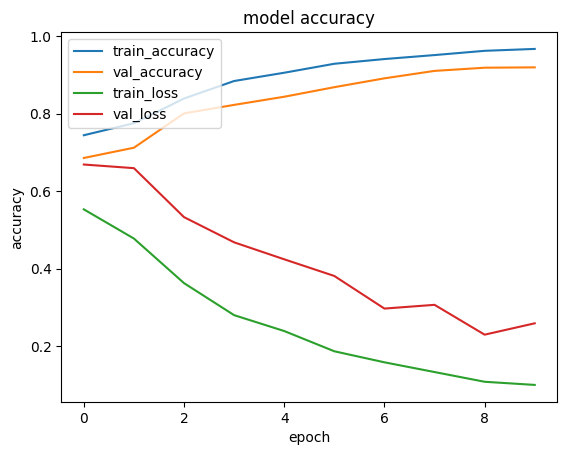

K-Fold Results:
Acuracy: 0.8725826293230057 	 +/- 0.045766738198340574
Precision: 0.7044006809592247 	 +/- 0.11412324120242388
Recall: 0.8993037268519402 	 +/- 0.06382334746070104
AUC: 0.9433270783620795 	 +/- 0.03666969580637607
F1: 0.7813483929445646 	 +/- 0.054563561071029144


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9346919655799866, Test Precision: 0.9096774458885193, Test Recall: 0.8103448152542114, Test AUC: 0.9729015557381154, Test F1 Score: 0.8571428620228593


In [27]:
# simclr china pretrain no smote

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=8, batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.0001, num_classes=1, name="resnet10_simclr_china_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9542190432548523, Val Precision: 0.8601694703102112, Val Recall: 0.918552041053772, Val AUC: 0.9921105835735965, Val F1 Score: 0.8884026167758025
Test Accuracy: 0.965261697769165, Test Precision: 0.8969804644584656, Test Recall: 0.967432975769043, Test AUC: 0.9962399679818001,Test F1 Score: 0.9308755893026179

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9278252720832825, Val Precision: 0.8213058710098267, Val Recall: 0.9087452292442322, Val AUC: 0.9759854646965396, Val F1 Score: 0.8628158924564202
Test Accuracy: 0.9564613103866577, Test Precision: 0.8474025726318359, Test Recall: 1.0, Test AUC: 0.9983417474728324,Test F1 Score: 0.9173989310024768

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9536861777305603, Val Precision: 0.9241379499435425, Val Recall: 0.9084745645523071, Val AUC: 0.9864229069018371, Val F1 Sc

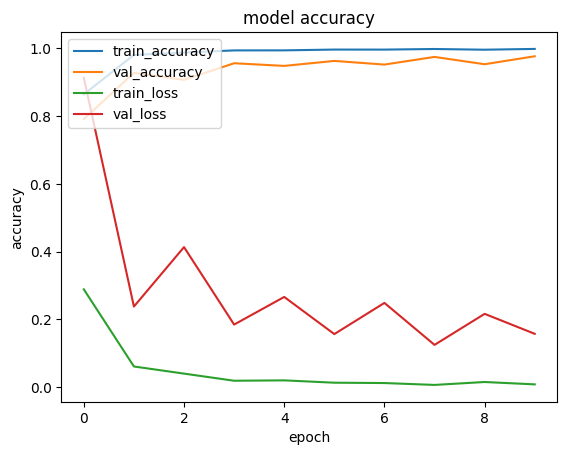

K-Fold Results:
Acuracy: 0.9515037536621094 	 +/- 0.01468553475837147
Precision: 0.8855541050434113 	 +/- 0.03884359817774906
Recall: 0.9312944188714027 	 +/- 0.04580824039292293
AUC: 0.9868327062482154 	 +/- 0.007807376381094777
F1: 0.9064818204363055 	 +/- 0.023200310570080485


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9717462062835693, Test Precision: 0.9022687673568726, Test Recall: 0.99042147397995, Test AUC: 0.9967876477155435, Test F1 Score: 0.9442922491749001


In [12]:
#simclr china pretrain smote

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.3123877942562103, Val Precision: 0.21406085789203644, Val Recall: 0.9230769276618958, Val AUC: 0.5790335084847963, Val F1 Score: 0.34752980957254304
Test Accuracy: 0.34923574328422546, Test Precision: 0.2662784457206726, Test Recall: 0.9636015295982361, Test AUC: 0.7027146424751378,Test F1 Score: 0.4172542406488861

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.38746437430381775, Val Precision: 0.25944584608078003, Val Recall: 0.7832699418067932, Val AUC: 0.5424363478846802, Val F1 Score: 0.3897824030715027
Test Accuracy: 0.3881426453590393, Test Precision: 0.2667834162712097, Test Recall: 0.8754789233207703, Test AUC: 0.6144902248529573,Test F1 Score: 0.4089485400006887

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.36200377345085144, Val Precision: 0.29028698801994324, Val Recall: 0.8915254473686218, Val AUC: 0.66

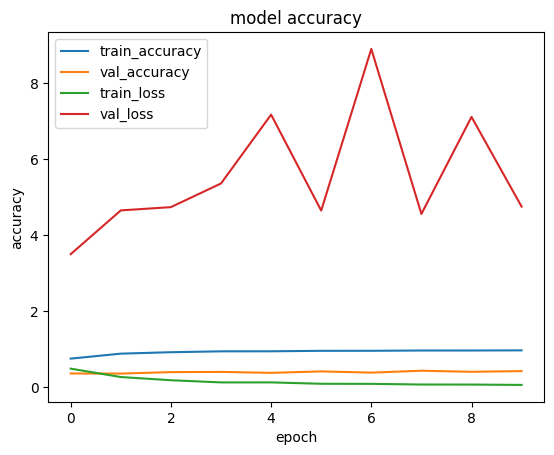

K-Fold Results:
Acuracy: 0.3763594962656498 	 +/- 0.11197604759220521
Precision: 0.27976710721850395 	 +/- 0.05985746166155739
Recall: 0.9030625894665718 	 +/- 0.06947559984244402
AUC: 0.626712029308779 	 +/- 0.12025361276680645
F1: 0.4236565111488326 	 +/- 0.07151471373745477


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.36915239691734314, Test Precision: 0.27321815490722656, Test Recall: 0.969348669052124, Test AUC: 0.748619683235149, Test F1 Score: 0.42628476748846666


In [13]:
# simclr china pretrain deep smote

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_deep_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9703770279884338, Val Precision: 0.9947368502616882, Val Recall: 0.8552036285400391, Val AUC: 0.9980694491596277, Val F1 Score: 0.9197080376740724
Test Accuracy: 0.960629940032959, Test Precision: 0.916190505027771, Test Recall: 0.9214559197425842, Test AUC: 0.9898889895308913,Test F1 Score: 0.9188156688795975

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.962013304233551, Val Precision: 0.995555579662323, Val Recall: 0.8517110347747803, Val AUC: 0.9888674977138182, Val F1 Score: 0.9180328018740079
Test Accuracy: 0.9657248854637146, Test Precision: 0.9552845358848572, Test Recall: 0.9003831148147583, Test AUC: 0.9887760762257846,Test F1 Score: 0.9270216739835919

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9064272046089172, Val Precision: 0.8656716346740723, Val Recall: 0.7864406704902649, Val AUC: 0.9537508052513

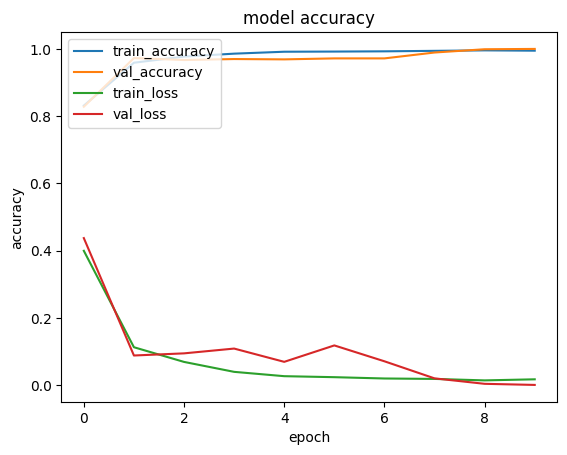

K-Fold Results:
Acuracy: 0.9519234672188759 	 +/- 0.028073575378653647
Precision: 0.9647773578763008 	 +/- 0.05249026340802937
Recall: 0.8498295396566391 	 +/- 0.10186758998437612
AUC: 0.9821040135857 	 +/- 0.01882497586775002
F1: 0.8992227361113452 	 +/- 0.06028743877222666


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9647985100746155, Test Precision: 0.9114391207695007, Test Recall: 0.946360170841217, Test AUC: 0.9858317125289932, Test F1 Score: 0.9285714403464543


In [14]:
# moco china pretrain no smote

k_fold_finetune_resnet(8, X_train, Y_train, folds_train, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_no_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.96499103307724, Val Precision: 0.9136363863945007, Val Recall: 0.9095022678375244, Val AUC: 0.9954497778093061, Val F1 Score: 0.9115646398871494
Test Accuracy: 0.9638721346855164, Test Precision: 0.8881118893623352, Test Recall: 0.9731800556182861, Test AUC: 0.9888439510645818,Test F1 Score: 0.9287020020858652

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.962013304233551, Val Precision: 0.9911894202232361, Val Recall: 0.855513334274292, Val AUC: 0.9766135630745536, Val F1 Score: 0.9183673590429121
Test Accuracy: 0.9555349946022034, Test Precision: 0.8915441036224365, Test Recall: 0.9291187524795532, Test AUC: 0.988274036469853,Test F1 Score: 0.9099436972220817

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.946124792098999, Val Precision: 0.9190140962600708, Val Recall: 0.8847457766532898, Val AUC: 0.968098718261989

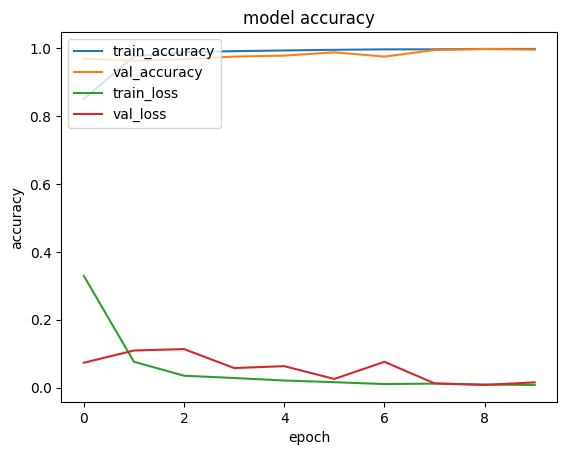

K-Fold Results:
Acuracy: 0.9630181789398193 	 +/- 0.021698488301254974
Precision: 0.9384241253137589 	 +/- 0.07238887432506828
Recall: 0.9215809404850006 	 +/- 0.04850782952648054
AUC: 0.9881971381687257 	 +/- 0.011182866288121844
F1: 0.9271802562747726 	 +/- 0.03965840464576324


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9763779640197754, Test Precision: 0.9626718759536743, Test Recall: 0.938697338104248, Test AUC: 0.9918971485546171, Test F1 Score: 0.9505334584616961


In [15]:
# moco china pretrain smote

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9676840305328369, Val Precision: 0.9894179701805115, Val Recall: 0.8461538553237915, Val AUC: 0.9985305518537849, Val F1 Score: 0.912195119103954
Test Accuracy: 0.9634090065956116, Test Precision: 0.9171375036239624, Test Recall: 0.9329501986503601, Test AUC: 0.9873577261460901,Test F1 Score: 0.9249762756044743

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9420702457427979, Val Precision: 0.9072580933570862, Val Recall: 0.855513334274292, Val AUC: 0.9637387495788612, Val F1 Score: 0.8806262506060618
Test Accuracy: 0.9573876857757568, Test Precision: 0.8937729001045227, Test Recall: 0.9348658919334412, Test AUC: 0.9916759702006052,Test F1 Score: 0.9138576771752157

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9319470524787903, Val Precision: 0.8585209250450134, Val Recall: 0.9050847291946411, Val AUC: 0.97155519026

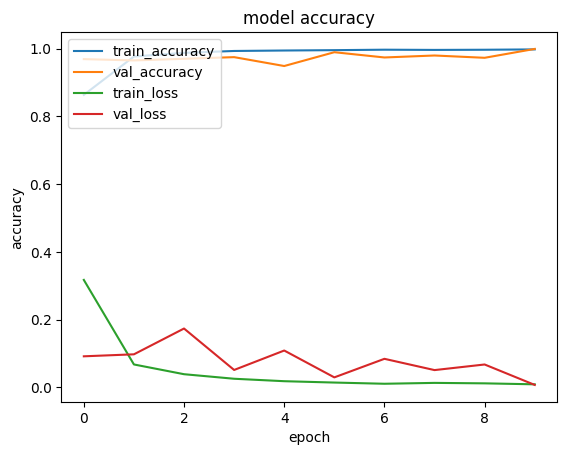

K-Fold Results:
Acuracy: 0.9662047401070595 	 +/- 0.02618519386772321
Precision: 0.9571887776255608 	 +/- 0.04687475048006546
Recall: 0.9135982841253281 	 +/- 0.06671098245979849
AUC: 0.9882542749087542 	 +/- 0.014013586361727191
F1: 0.9335080772062785 	 +/- 0.046406375440543504


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9712830185890198, Test Precision: 0.918181836605072, Test Recall: 0.967432975769043, Test AUC: 0.9925817482217963, Test F1 Score: 0.9421642009329858


In [28]:
# moco china pretrain smote v2 sanity check

k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9712746739387512, Val Precision: 0.8953974843025208, Val Recall: 0.9683257937431335, Val AUC: 0.9914696001580924, Val F1 Score: 0.9304347806526717
Test Accuracy: 0.9624826312065125, Test Precision: 0.8705882430076599, Test Recall: 0.992337167263031, Test AUC: 0.9969702076267913,Test F1 Score: 0.9274843385094949

Training on fold 2
68/68 [==============================] - 0s 5ms/step
Val Accuracy: 0.9221272468566895, Val Precision: 0.773413896560669, Val Recall: 0.9733840227127075, Val AUC: 0.9918371275930115, Val F1 Score: 0.8619528584843877
Test Accuracy: 0.9411764740943909, Test Precision: 0.8043143153190613, Test Recall: 1.0, Test AUC: 0.9976940108646551,Test F1 Score: 0.8915456785885251

Training on fold 3
68/68 [==============================] - 0s 3ms/step
Val Accuracy: 0.9631379842758179, Val Precision: 0.8926380276679993, Val Recall: 0.9864406585693359, Val AUC: 0.9944243285869783, Val F1 S

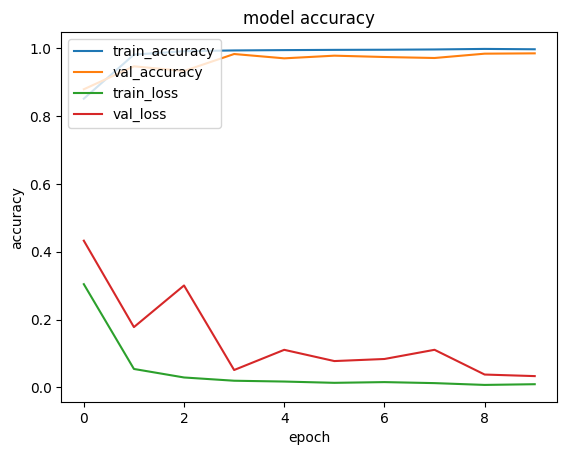

K-Fold Results:
Acuracy: 0.9571049138903618 	 +/- 0.02421944224647009
Precision: 0.9004432857036591 	 +/- 0.06500956584658985
Recall: 0.945980854332447 	 +/- 0.04865400895047024
AUC: 0.9881996836091388 	 +/- 0.012139611101964166
F1: 0.9201691019525766 	 +/- 0.036402953980808346


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.9759147763252258, Test Precision: 0.9737903475761414, Test Recall: 0.9252873659133911, Test AUC: 0.9975764001526014, Test F1 Score: 0.948919466813152


In [21]:
# simclr china pretrain smote (8 layers frozen, peformed better than 7)
k_fold_finetune_resnet(8, X_train_resampled, Y_train_resampled, folds_train_resampled, X_train, Y_train, folds_train, freeze_layers=8,batch_size=32, epochs=10, weights_path='models/resnet10_simclr_china_pretrain_epoch_5.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_smote.h5")


Training on fold 1
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.9084380865097046, Val Precision: 0.8020304441452026, Val Recall: 0.7149321436882019, Val AUC: 0.9249568032915638, Val F1 Score: 0.7559808650981733
Test Accuracy: 0.8286243677139282, Test Precision: 0.6513944268226624, Test Recall: 0.6264367699623108, Test AUC: 0.883725720116932,Test F1 Score: 0.638671871115548

Training on fold 2
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.7283950448036194, Val Precision: 0.4510638415813446, Val Recall: 0.4030418395996094, Val AUC: 0.6665639890263272, Val F1 Score: 0.42570282458827385
Test Accuracy: 0.8110235929489136, Test Precision: 0.60326087474823, Test Recall: 0.6379310488700867, Test AUC: 0.8377416870876312,Test F1 Score: 0.6201117413792768

Training on fold 3
68/68 [==============================] - 0s 4ms/step
Val Accuracy: 0.721172034740448, Val Precision: 0.5, Val Recall: 0.6271186470985413, Val AUC: 0.7237154852611236, Val F1 Sco

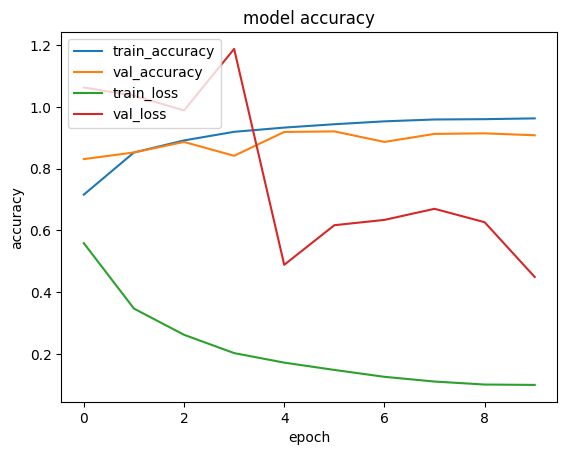

K-Fold Results:
Acuracy: 0.7052297703921795 	 +/- 0.14421655323642374
Precision: 0.47385504096746445 	 +/- 0.1712586554238786
Recall: 0.47670998238027096 	 +/- 0.21984472760431809
AUC: 0.712970382359318 	 +/- 0.10518442150991739
F1: 0.44924373395727946 	 +/- 0.15699375596658666


68/68 [==============================] - 1s 4ms/step

Test Performance:
Test Accuracy: 0.8286243677139282, Test Precision: 0.6513944268226624, Test Recall: 0.6264367699623108, Test AUC: 0.883725720116932, Test F1 Score: 0.638671871115548


In [16]:
# moco china pretrain deep smote

k_fold_finetune_resnet(8, X_train_resampled_deep, Y_train_resampled_deep, folds_train_resampled_deep, X_train, Y_train, folds_train, freeze_layers=7,batch_size=32, epochs=10, weights_path='model-weights/test_moco_DAT_China_pretrain_1s_HB_4.h5', learning_rate=0.001, num_classes=1, name="resnet10_china_pretrain_moco_deep_smote.h5")